# 公式Example
深層学習フレームワークには公式に様々なモデルのExampleコードが公開されています。

## 【問題1】公式Exampleを分担して実行
TensorFLowの公式Exampleを分担して実行してください。

以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。

research

定番のモデルから最新のモデルまで多様なコードが公開されています。

models/research at master · tensorflow/models

tutorials

TensorFLowのチュートリアルとして用意された簡単なモデルが含まれています。

models/tutorials at master · tensorflow/models

In [1]:
# Install imgeio in order to generate an animated gif showing the image generating process
!pip install imageio

Import TensorFlow and enable eager execution

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
  
    return model

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model

In [9]:
generator = make_generator_model()
discriminator = make_discriminator_model()


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [0]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [0]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [0]:
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random_normal([BATCH_SIZE, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [16]:
train_step = tf.contrib.eager.defun(train_step)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
def train(dataset, epochs):  
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      train_step(images)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


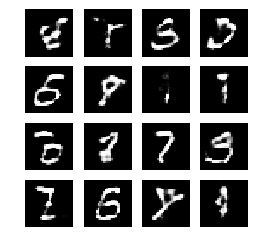

CPU times: user 4min 49s, sys: 1min 21s, total: 6min 11s
Wall time: 22min 24s


In [19]:
%%time
train(train_dataset, EPOCHS)

In [20]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [21]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp dcgan.gif dcgan.gif.png')

0

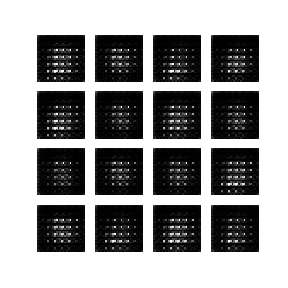

In [22]:
display.Image(filename="dcgan.gif.png")

In [0]:
from google.colab import files
files.download('dcgan.gif.png')

# 異なるフレームワークへの書き換え
Sprint14で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。

Iris（Iris-versicolorとIris-virginicaのみの2値分類）
Iris（3種類全ての目的変数を使用して多値分類）
House Prices
MNIST

## 【問題2】Iris（2値分類）をKerasで学習
Sprint14で作成したIrisデータセットに対する2値分類をKerasに書き換えてください。

In [2]:
"""
Irisデータセットのimport(2値分類)
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出 
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
iris_X_train, iris_X_val, iris_y_train, iris_y_val = train_test_split(iris_X_train, iris_y_train, test_size=0.2, random_state=0)

In [3]:
import tensorflow as tf

model = tf.keras.Sequential([tf.keras.layers.Dense(1, activation = tf.nn.sigmoid, input_shape=(4,))])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])


history = model.fit(iris_X_train, iris_y_train,
                    batch_size=1,
                    epochs=100,
                    verbose=1,
                    validation_data=(iris_X_val, iris_y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Train on 64 samples, validate on 16 samples
Epoch 1/100
64/64 [==============================] - 1s 12ms/step - loss: 0.7457 - acc: 0.6562 - val_loss: 0.5987 - val_acc: 0.8750
Epoch 2/100
64/64 [==============================] - 0s 2ms/step - loss: 0.6155 - acc: 0.6875 - val_loss: 0.6194 - val_acc: 0.6250
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 0.6108 - acc: 0.6562 - val_loss: 0.5917 - val_acc: 0.6875
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 0.5834 - acc: 0.7344 - val_loss: 0.5859 - val_acc: 0.6875
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 0.5716 - acc: 0.7969 - val_loss: 0

64/64 [==============================] - 0s 2ms/step - loss: 0.2489 - acc: 0.9531 - val_loss: 0.1973 - val_acc: 1.0000
Epoch 60/100
64/64 [==============================] - 0s 1ms/step - loss: 0.2508 - acc: 0.9375 - val_loss: 0.1997 - val_acc: 1.0000
Epoch 61/100
64/64 [==============================] - 0s 1ms/step - loss: 0.2447 - acc: 0.9531 - val_loss: 0.2045 - val_acc: 1.0000
Epoch 62/100
64/64 [==============================] - 0s 1ms/step - loss: 0.2394 - acc: 0.9531 - val_loss: 0.2263 - val_acc: 1.0000
Epoch 63/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2461 - acc: 0.9844 - val_loss: 0.2061 - val_acc: 1.0000
Epoch 64/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2315 - acc: 0.9531 - val_loss: 0.2360 - val_acc: 1.0000
Epoch 65/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2509 - acc: 0.9375 - val_loss: 0.2006 - val_acc: 1.0000
Epoch 66/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2344 - acc: 0

In [4]:
y_pred_proba = model.predict(iris_X_test)[:, 0]

# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)

print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)

y_pred_proba [0.1756402  0.98397785 0.17215998 0.98106223 0.83039886 0.9819634
 0.40826243 0.7759107  0.984501   0.9459387  0.9260635  0.9462535
 0.97750354 0.28996074 0.04233227 0.07929465 0.5893759  0.0638186
 0.793097   0.09202248]
y_pred [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0]


In [5]:
score = model.evaluate(iris_X_test, iris_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23610961437225342
Test accuracy: 0.8999999761581421


## 【問題3】Iris（多値分類）をKerasで学習
Sprint14で作成したIrisデータセットに対する3値分類をKerasに書き換えてください。

In [7]:
"""
Irisデータセットのimport(3値分類)
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出 Iris-setosa
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")|(df["Species"] == "Iris-setosa")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2

y = y.astype(np.int)[:, np.newaxis]

#ワンホット化
zero = np.zeros((y.shape[0], 3))
for i in range(len(y)):
    zero[i, y[i,0]] = 1
y = zero

# trainとtestに分割
iris3_X_train, iris3_X_test, iris3_y_train, iris3_y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
iris3_X_train, iris3_X_val, iris3_y_train, iris3_y_val = train_test_split(iris3_X_train, iris3_y_train, test_size=0.2, random_state=0)

In [8]:
import tensorflow as tf

model = tf.keras.Sequential([tf.keras.layers.Dense(3, activation = tf.nn.softmax, input_shape=(4,))])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])


history = model.fit(iris3_X_train, iris3_y_train,
                    batch_size=1,
                    epochs=100,
                    verbose=1,
                    validation_data=(iris3_X_val, iris3_y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
Train on 96 samples, validate on 24 samples
Epoch 1/100
96/96 [==============================] - 1s 8ms/step - loss: 0.5722 - acc: 0.7083 - val_loss: 0.4565 - val_acc: 0.7639
Epoch 2/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4238 - acc: 0.8056 - val_loss: 0.3918 - val_acc: 0.8056
Epoch 3/100
96/96 [==============================] - 0s 2ms/step - loss: 0.3623 - acc: 0.8333 - val_loss: 0.3484 - val_acc: 0.8056
Epoch 4/100
96/96 [==============================] - 0s 2ms/step - loss: 0.3195 - acc: 0.8299 - val_loss: 0.3300 - val_acc: 0.8056
Epoch 5/100
96/96 [==============================] - 0s 2ms/step - loss: 0.2895 - acc: 0.8542 - val_loss: 

96/96 [==============================] - 0s 2ms/step - loss: 0.0740 - acc: 0.9722 - val_loss: 0.1258 - val_acc: 0.9444
Epoch 60/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0624 - acc: 0.9861 - val_loss: 0.1666 - val_acc: 0.9444
Epoch 61/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0584 - acc: 0.9861 - val_loss: 0.1502 - val_acc: 0.9444
Epoch 62/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0737 - acc: 0.9792 - val_loss: 0.1230 - val_acc: 0.9444
Epoch 63/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0594 - acc: 0.9931 - val_loss: 0.1251 - val_acc: 0.9444
Epoch 64/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0537 - acc: 1.0000 - val_loss: 0.2699 - val_acc: 0.8889
Epoch 65/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0738 - acc: 0.9653 - val_loss: 0.1267 - val_acc: 0.9444
Epoch 66/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0572 - acc: 0

In [9]:
y_pred_proba = model.predict(iris3_X_test)[:, 0]

# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)

print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)

y_pred_proba [1.9340783e-12 3.0824341e-04 9.9999630e-01 9.1121589e-11 9.9988091e-01
 3.8040389e-14 9.9993563e-01 3.3636701e-05 1.7983841e-05 4.0429615e-04
 6.3810117e-09 7.0999013e-05 2.9711655e-05 1.4075207e-05 1.0325245e-05
 9.9980706e-01 1.1497958e-05 2.1978021e-05 9.9943250e-01 9.9998081e-01
 4.9112281e-10 6.0503667e-06 9.9911338e-01 9.9920899e-01 9.5779939e-08
 9.9998629e-01 9.9947661e-01 1.6766641e-04 1.9855937e-03 9.9946517e-01]
y_pred [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1]


In [10]:
score = model.evaluate(iris3_X_test, iris3_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07567395269870758
Test accuracy: 0.9777777791023254


## 【問題4】House PricesをKerasで学習
Sprint14で作成したHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [11]:
"""
housepriceデータセットのimport
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# データセットの読み込み
dataset_path ="train.csv"
df = pd.read_csv(dataset_path)
y = df["SalePrice"]
X = df.loc[:,['GrLivArea', 'YearBuilt']]
y = np.array(y)
X = np.array(X)
y = np.log(y) #分布偏ってるのでlog
y = y.astype("float32")[:, np.newaxis]
# trainとtestに分割
house_X_train, house_X_test, house_y_train, house_y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
house_X_train, house_X_val, house_y_train, house_y_val = train_test_split(house_X_train, house_y_train, test_size=0.2, random_state=0)
#標準化
sc = StandardScaler()
house_X_train = sc.fit_transform(house_X_train).astype("float32")
house_X_val = sc.transform(house_X_val).astype("float32")
house_X_test = sc.transform(house_X_test).astype("float32")

/anaconda/envs/tesflowmachine/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/envs/tesflowmachine/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/envs/tesflowmachine/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/envs/tesflowmachine/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
print(house_X_train.shape)
print(house_X_test.shape)

(934, 2)
(292, 2)


In [13]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(13, input_dim=2, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])


history = model.fit(house_X_train, house_y_train,
                    batch_size=10,
                    epochs=100,
                    verbose=1,
                    validation_data=(house_X_val, house_y_val))

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                39        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 14        
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________
Train on 934 samples, validate on 234 samples
Epoch 1/100
934/934 [==============================] - 1s 790us/step - loss: 142.2817 - mean_squared_error: 142.2817 - val_loss: 138.3056 - val_mean_squared_error: 138.3056
Epoch 2/100
934/934 [==============================] - 0s 156us/step - loss: 132.4969 - mean_squared_error: 132.4969 - val_loss: 124.6231 - val_mean_squared_error: 124.6231
Epoch 3/100
934/934 [==============================] - 0s 153us/step - loss: 115.0918 - mean_squared_error: 115.0918 - val_loss: 103.9262 - val_mean_s

934/934 [==============================] - 0s 139us/step - loss: 0.0570 - mean_squared_error: 0.0570 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 47/100
934/934 [==============================] - 0s 139us/step - loss: 0.0565 - mean_squared_error: 0.0565 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 48/100
934/934 [==============================] - 0s 146us/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.0424 - val_mean_squared_error: 0.0424
Epoch 49/100
934/934 [==============================] - 0s 151us/step - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 50/100
934/934 [==============================] - 0s 150us/step - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Epoch 51/100
934/934 [==============================] - 0s 149us/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 0.0421 - val_mean_squared_error: 0.0421
Epoch 52/100
934/

934/934 [==============================] - 0s 162us/step - loss: 0.0487 - mean_squared_error: 0.0487 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 96/100
934/934 [==============================] - 0s 157us/step - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 97/100
934/934 [==============================] - 0s 152us/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 98/100
934/934 [==============================] - 0s 144us/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 99/100
934/934 [==============================] - 0s 157us/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0441 - val_mean_squared_error: 0.0441
Epoch 100/100
934/934 [==============================] - 0s 158us/step - loss: 0.0484 - mean_squared_error: 0.0484 - val_loss: 0.0437 - val_mean_squared_error: 0.0437


In [16]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,val_loss,val_mean_squared_error,loss,mean_squared_error,epoch
0,138.305636,138.305636,142.281687,142.281687,0
1,124.623072,124.623072,132.496939,132.496939,1
2,103.926155,103.926155,115.091757,115.091757,2
3,78.397624,78.397624,91.584429,91.584429,3
4,52.597556,52.597556,65.432457,65.432457,4


## 【問題5】MNISTをKerasで学習
Sprint14で作成したMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [17]:
# import MNIST data
import numpy as np
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
mnist_X_test = X_test.astype(np.float)
X_train /= 255
mnist_X_test /= 255

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
mnist_y_train = enc.fit_transform(y_train[:, np.newaxis])
mnist_y_test = enc.transform(y_test[:, np.newaxis])


mnist_X_train, mnist_X_val, mnist_y_train, mnist_y_val = train_test_split(X_train, mnist_y_train, test_size=0.2)

In [19]:
import tensorflow as tf

model = tf.keras.Sequential([tf.keras.layers.Dense(10, activation = tf.nn.softmax, input_shape=(784,))])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])


history = model.fit(mnist_X_train, mnist_y_train,
                    batch_size=30,
                    epochs=10,
                    verbose=1,
                    validation_data=(mnist_X_val, mnist_y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 105us/step - loss: 0.0634 - acc: 0.9796 - val_loss: 0.0572 - val_acc: 0.9824
Epoch 2/10
48000/48000 [==============================] - 4s 92us/step - loss: 0.0577 - acc: 0.9824 - val_loss: 0.0590 - val_acc: 0.9829
Epoch 3/10
48000/48000 [==============================] - 4s 88us/step - loss: 0.0557 - acc: 0.9833 - val_loss: 0.0577 - val_acc: 0.9829
Epoch 4/10
48000/48000 [==============================] - 5s 95us/step - loss: 0.0545 - acc: 0.9838 - val_loss: 0.0597 - val_acc: 0.9830
Epoch 5/10
48000/48000 [==============================] - 4s 91us/ste

In [20]:
y_pred_proba = model.predict(mnist_X_test)[:, 0]

# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)

print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)

y_pred_proba [2.0721728e-11 1.2224855e-07 1.9133151e-14 ... 5.0139659e-20 7.8156213e-17
 1.4721880e-14]
y_pred [0 0 0 ... 0 0 0]


In [21]:
score = model.evaluate(mnist_X_test, mnist_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06949166253712029
Test accuracy: 0.9818200090408326


## 【問題6】（アドバンス課題）PyTorchへの書き換え
4種類の問題をPyTorchに書き換えてください。

## 【問題7】（アドバンス課題）フレームワークの比較
それぞれのフレームワークにはどのような違いがあるかをまとめてください。

興味がある場合はTensorFlow、Keras、PyTorch以外にも触れてみましょう。

視点例

計算速度
コードの行数・可読性
用意されている機能